In [ ]:
import sys
sys.path.append(r"D:\timesformer")  # timesformer 경로를 python 모듈 경로에 추가

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from pathlib import Path
import numpy as np
import random
from decord import VideoReader
from tqdm import tqdm
from timesformer.models.vit import TimeSformer

from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode
import pickle

def preprocess_tensor(img_tensor):  # img_tensor: (3, H, W)
    img = F.resize(img_tensor, 256, interpolation=InterpolationMode.BICUBIC)
    img = F.center_crop(img, IMG_SIZE)
    img = F.normalize(img, [0.45]*3, [0.225]*3)
    return img

# ----------------- 하이퍼파라미터 ----------------------------
ROOT          = Path(r"D:\golfDataset\dataset\train")
PRETRAIN_PYTH = Path(r"D:\timesformer\pretrained\TimeSformer_divST_96x4_224_K600.pyth")
NUM_FRAMES    = 32
CLIPS_PER_VID = 5
IMG_SIZE      = 224
BATCH         = 4
LR            = 1e-3
EPOCHS        = 5
SEED          = 42
TEST_RATIO    = 0.1     # 테스트셋 비율

# ----------------- 재현성 ----------------------------
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
device = "cuda"  # 무조건 gpu 사용 안되면 오류 내버리기

# ----------------- 전처리 ----------------------------
base_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.45]*3, [0.225]*3),
])

def uniform_sample(L, N):
    if L >= N:
        return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

def load_clip(path: Path):  # 비디오를 timesformer 입력에 맞게 전처리
    vr = VideoReader(str(path))
    L = len(vr)
    seg_edges = np.linspace(0, L, CLIPS_PER_VID + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)              # (T, H, W, 3)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).float() / 255.0  # (T, 3, H, W)
        clip = torch.stack([preprocess_tensor(f) for f in clip])         # (T, 3, H, W)
        clips.append(clip.permute(1, 0, 2, 3))                            # (3, T, H, W)
    return clips  # list of (3, T, H, W)

# ----------------- 데이터셋 ----------------------------
class SwingDataset(Dataset):
    def __init__(self, root: Path):
        self.samples = []
        for lbl, sub in enumerate(("balanced_true", "false")):
            for p in (root/sub/"crop_video").glob("*.mp4"):
                self.samples.append((p, lbl))
        print(f"\u2705 {len(self.samples)} samples found in {root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, lbl = self.samples[i]
        clips = load_clip(path)
        return torch.stack(clips), torch.tensor(lbl)

# ----------------- 데이터 로더 ----------------------------
ds_full = SwingDataset(ROOT)
n_test = int(len(ds_full)*TEST_RATIO)
n_train = len(ds_full) - n_test
train_ds, test_ds = random_split(ds_full, [n_train, n_test])
train_ld = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
test_ld  = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# ----------------- Checkpoint 설정 ----------------------------
checkpoint_path = Path("checkpoint.pth")  # 🔧 체크포인트 저장 경로
start_epoch = 0  # 🔧 기본값

# ----------------- 모델 ----------------------------
model = TimeSformer(img_size=IMG_SIZE, num_frames=NUM_FRAMES,
                    num_classes=2, attention_type='divided_space_time',
                    pretrained_model=str(PRETRAIN_PYTH)).to(device)

# 분류 레이어만 학습하도록 설정
def get_trainable_params(model):
    trainable = []
    for name, param in model.named_parameters():
        if any(x in name for x in ('head', 'cls_head')):
            param.requires_grad = True
            trainable.append(param)
        else:
            param.requires_grad = False
    return trainable

opt = optim.AdamW(get_trainable_params(model), lr=LR, weight_decay=0.02)
crit = nn.CrossEntropyLoss()

# 🔧 Checkpoint가 존재하면 불러오기
if checkpoint_path.exists():
    print(f"🔁 Loading checkpoint from {checkpoint_path}")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    opt.load_state_dict(ckpt["opt"])
    start_epoch = ckpt["epoch"] + 1
    print(f"✅ Resuming from epoch {start_epoch}")

# ----------------- 학습 ----------------------------
train_logs = {"train_acc": [], "test_acc": [], "train_loss": []}

for ep in range(start_epoch, EPOCHS):
    model.train()
    tot = correct = total_loss = 0
    for clips, lab in tqdm(train_ld, desc=f"Epoch {ep}", ncols=70):
        vids = clips.squeeze(0).to(device)  # (5,3,T,H,W)
        labs = lab.repeat(CLIPS_PER_VID).to(device)
        outs = model(vids)  # (5,2)
        loss = crit(outs, labs)
        opt.zero_grad(); loss.backward(); opt.step()

        total_loss += loss.item()
        tot += labs.size(0); correct += (outs.argmax(1) == labs).sum().item()

    train_acc = correct / tot
    avg_loss = total_loss / tot
    train_logs["train_acc"].append(train_acc)
    train_logs["train_loss"].append(avg_loss)
    print(f"  train acc: {train_acc:.3%}, loss: {avg_loss:.4f}")

    # ✔ 테스트 정확도 기록
    model.eval(); test_tot = test_correct = 0
    with torch.no_grad():
        for clips, lab in test_ld:
            vids = clips.squeeze(0).to(device)
            probs = model(vids).softmax(1).mean(0, keepdim=True)
            pred = probs.argmax(1)
            test_tot += 1; test_correct += (pred.cpu() == lab).item()
    test_acc = test_correct / test_tot
    train_logs["test_acc"].append(test_acc)
    print(f"  test  acc: {test_acc:.3%}")

    # ✔ 로그 저장
    with open("train_logs.pkl", "wb") as f:
        pickle.dump(train_logs, f)

    # ✔ 체크포인트 저장
    torch.save({
        "epoch": ep,
        "model": model.state_dict(),
        "opt": opt.state_dict(),
    }, checkpoint_path)

# 🔧 최종 학습된 모델 저장
final_model_path = Path("timesformer_finetuned.pth")
torch.save({
    "epoch": EPOCHS - 1,
    "model": model.state_dict(),
    "opt": opt.state_dict(),
}, final_model_path)
print(f"\n✅ Final model saved to {final_model_path}")


✅ 436 samples found in D:\golfDataset\스포츠 사람 동작 영상(골프)\Training\Public\male\train


Epoch 0: 100%|██████████████████████| 393/393 [10:55<00:00,  1.67s/it]


  train acc: 65.954%, loss: 0.1284
  test  acc: 62.791%


Epoch 1: 100%|██████████████████████| 393/393 [10:51<00:00,  1.66s/it]


  train acc: 80.916%, loss: 0.0866
  test  acc: 74.419%


Epoch 2: 100%|██████████████████████| 393/393 [10:51<00:00,  1.66s/it]


  train acc: 86.209%, loss: 0.0661
  test  acc: 74.419%


Epoch 3: 100%|██████████████████████| 393/393 [10:53<00:00,  1.66s/it]


  train acc: 86.412%, loss: 0.0604
  test  acc: 72.093%


Epoch 4: 100%|██████████████████████| 393/393 [10:52<00:00,  1.66s/it]


  train acc: 89.160%, loss: 0.0532
  test  acc: 79.070%

✅ Final model saved to timesformer_finetuned.pth


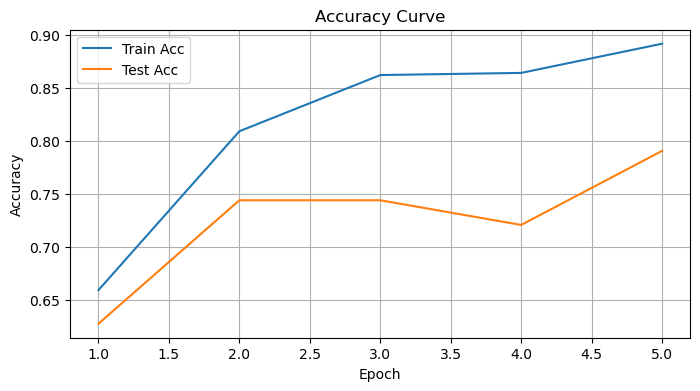

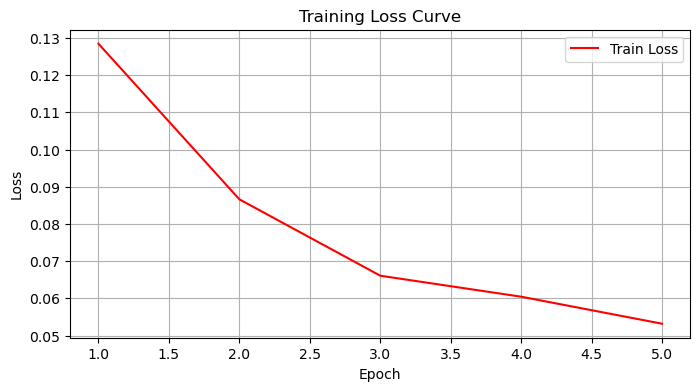

In [3]:
import pickle
import matplotlib.pyplot as plt

# 로그 불러오기
with open("train_logs.pkl", "rb") as f:
    logs = pickle.load(f)

epochs = list(range(1, len(logs["train_acc"]) + 1))

# 정확도 그래프
plt.figure(figsize=(8, 4))
plt.plot(epochs, logs["train_acc"], label="Train Acc")
plt.plot(epochs, logs["test_acc"], label="Test Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend(); plt.show()

# 손실 그래프
plt.figure(figsize=(8, 4))
plt.plot(epochs, logs["train_loss"], label="Train Loss", color="red")
plt.title("Training Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend(); plt.show()


TEST

In [ ]:
import sys
sys.path.append(r"D:\timesformer")  # TimeSformer 모듈 경로 추가

import torch
from pathlib import Path
import numpy as np
from decord import VideoReader
import torchvision.transforms as T
from torchvision.transforms import functional as F, InterpolationMode
from torch.utils.data import Dataset, DataLoader
from timesformer.models.vit import TimeSformer


# ----------------- 설정 ----------------------------
TEST_ROOT      = Path(r"D:\golfDataset\dataset\test")
NUM_FRAMES     = 32
CLIPS_PER_VID  = 5
IMG_SIZE       = 224
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH     = Path("timesformer_finetuned.pth")  # fine-tuned 모델 파일 경로
BATCH_SIZE     = 1
NUM_WORKERS    = 0

# ----------------- 헬퍼 함수 -------------------------
def uniform_sample(L, N):
    if L >= N:
        return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

def preprocess_tensor(img_tensor):  # img_tensor: (3, H, W)
    img = F.resize(img_tensor, 256, interpolation=InterpolationMode.BICUBIC)
    img = F.center_crop(img, IMG_SIZE)
    img = F.normalize(img, [0.45]*3, [0.225]*3)
    return img

def load_clip(path: Path):
    vr = VideoReader(str(path))
    L = len(vr)
    seg_edges = np.linspace(0, L, CLIPS_PER_VID + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)        # (T, H, W, 3)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).float() / 255.0
        clip = torch.stack([preprocess_tensor(f) for f in clip])   # (T, 3, H, W)
        clips.append(clip.permute(1, 0, 2, 3))                       # (3, T, H, W)
    return clips

# ----------------- Dataset 정의 -----------------------
class SwingTestDataset(Dataset):
    def __init__(self, root: Path):
        self.samples = []
        for lbl, sub in enumerate(("balanced_true", "false")):
            folder = root / sub / "crop_video"
            if folder.exists():
                for p in folder.glob("*.mp4"):
                    self.samples.append((p, lbl))
        print(f"🔎 {len(self.samples)} test samples found in {root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        clips = load_clip(path)
        return torch.stack(clips), torch.tensor(lbl)

# ----------------- 모델 로드 --------------------------
print("⏳ 모델 로드 중...")
# 모델 생성
model = TimeSformer(
    img_size=IMG_SIZE,
    num_frames=NUM_FRAMES,
    num_classes=2,
    attention_type='divided_space_time',
    pretrained_model=str(MODEL_PATH)  # fine-tuned 모델 경로
).to(DEVICE)

# finetuned weight만 로드
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['model'])
model.eval()
print("✅ 모델 로드 완료")

# ----------------- 평가 ------------------------------
test_ds = SwingTestDataset(TEST_ROOT)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                     num_workers=NUM_WORKERS, pin_memory=True)

total = correct = 0
with torch.no_grad():
    for clips, labels in test_ld:
        vids = clips.squeeze(0).to(DEVICE)  # (5,3,T,H,W)
        labels = labels.to(DEVICE)
        probs = model(vids).softmax(1).mean(0, keepdim=True)
        pred = probs.argmax(1)
        total += 1
        correct += (pred == labels).sum().item()

accuracy = correct / total if total > 0 else 0
print(f"🎯 Test Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")


⏳ 모델 로드 중...


KeyError: 'head.weight'

In [9]:
import torch
from pathlib import Path

# 원본 체크포인트 경로
MODEL_PATH = Path("timesformer_finetuned.pth")

# 1) 로드
ckpt = torch.load(MODEL_PATH, map_location="cpu")

# 2) wrapper 안에 'model' 키가 있으면 꺼내고, 없으면 그대로 state_dict로 간주
if isinstance(ckpt, dict) and "model" in ckpt:
    state_dict = ckpt["model"]
    # (선택) 원본 백업
    backup_path = MODEL_PATH.with_suffix(".backup.pth")
    if not backup_path.exists():
        print(f"🔖 백업 저장: {backup_path}")
        torch.save(ckpt, backup_path)
else:
    print("⚠️ 'model' 키가 없습니다. 이미 순수 state_dict일 수 있습니다.")
    state_dict = ckpt

# 3) 순수 state_dict만 덮어쓰기
torch.save(state_dict, MODEL_PATH)
print(f"✅ {MODEL_PATH.name} 을(를) 순수 state_dict 형태로 업데이트했습니다.")


🔖 백업 저장: timesformer_finetuned.backup.pth
✅ timesformer_finetuned.pth 을(를) 순수 state_dict 형태로 업데이트했습니다.
